In [1]:
from __future__ import print_function

from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras import callbacks
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Lambda, merge, Dropout
from keras.models import Model
from keras import backend as K
from keras.utils.visualize_util import plot
from IPython.display import Image

import os
import numpy as np
import pandas as pd
import six


import json
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
### Data Load

In [3]:
df = pd.read_csv("data/impurity_SiGe.csv")
y = df["TC"].as_matrix().astype("float32")
X = df.iloc[:, 0:-1].as_matrix().astype("float32")

index = np.random.permutation(np.arange(X.shape[0]))
Xtest = X[index[0:2000], :]
Xtrain = X [index[2000:], :]
ytest = y[index[0:2000]]

In [4]:
# Meta Parameter 
max_epochs = 100 # Maximum Number of Epochs 
batch_size = 500 # Minibatch Size
# n_zdim = 2 # Degree of freedom  in the latent space 
# z_epsilon = 1.0 # scale parameter of prior of latent variable z 

In [5]:
# Sampling Function 
# Variational AutoEncoder の特徴 
# z_epsilon -> 0 であれば標準のautoencoder
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(2,), mean=0., std=1.0)
    return z_mean + z_sigma * epsilon

In [6]:
# Encoder Layer p(z|x)
# 3層ネットワーク
x = Input(shape=(Xtrain.shape[1],)) # 入力層
hidden = Dense(200, activation='relu')(x)  # 隠れ層
d_hidden = Dropout(0.5)(hidden)
z_mean = Dense(2, activation='linear')(d_hidden) # p(z|x)の平均
z_sigma = Dense(2, activation='linear')(d_hidden) # p(z|x)の標準偏差
z = Lambda(sampling, output_shape=(2,))([z_mean, z_sigma]) # z 〜 p(z|x)

In [7]:
# Decoder Layer p(x|z)
decoder_h = Dense(200, activation='relu')
decoder_mean = Dense(Xtrain.shape[1], activation='sigmoid')
h_decoded = decoder_h(z)
d_h_decoded = Dropout(0.5)(h_decoded)
x_decoded_mean = decoder_mean(d_h_decoded)

In [8]:
# Variational AutoEncoder Model の定義
vae = Model(x, x_decoded_mean)

# Encoder Model の定義
encoder = Model(x,z)

# Decoder Model の定義
z_in = Input(shape=(2, ))
_h_decoded = decoder_h(z_in)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder= Model(input=z_in, output=_x_decoded_mean)

In [18]:
vae.load_weights("model/vae.hdf5")

In [9]:
def binary_crossentropy(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_pred, y_true), axis=-1)

In [10]:
def vae_loss(x, x_decoded_mean):
    reconst_loss = K.mean(binary_crossentropy(x, x_decoded_mean),axis=-1)
    latent_loss =  - 0.5 * K.mean(K.sum(1 + K.log(K.square(z_sigma)) - K.square(z_mean) - K.square(z_sigma), axis=-1))
    return reconst_loss + latent_loss

In [11]:
vae.compile(optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.), loss=vae_loss)

In [12]:
# Design callback functions
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")
    
# Early stopping に関する
es_cb = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='auto')

# 
cp_cb = ModelCheckpoint(filepath = os.path.join("checkpoint",'vae{epoch:02d}.hdf5'), 
                                              monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cbks = [cp_cb, es_cb]

In [13]:
if os.path.exists("checkpoint"):
    shutil.rmtree("checkpoint")
    os.mkdir("checkpoint")

history = vae.fit(Xtrain, Xtrain, nb_epoch=max_epochs, batch_size=batch_size, callbacks=cbks, shuffle = True,  validation_data=(Xtest, Xtest))

Train on 10870 samples, validate on 2000 samples
Epoch 1/100
10870/10870 [==============================] - 0s - loss: 13.8137 - val_loss: 14.1847
Epoch 2/100
10870/10870 [==============================] - 0s - loss: 13.7151 - val_loss: 13.9905
Epoch 3/100
10870/10870 [==============================] - 0s - loss: 13.6333 - val_loss: 13.9203
Epoch 4/100
10870/10870 [==============================] - 0s - loss: 13.6034 - val_loss: 13.8985
Epoch 5/100
10870/10870 [==============================] - 0s - loss: 13.5687 - val_loss: 13.8767
Epoch 6/100
10870/10870 [==============================] - 0s - loss: 13.5438 - val_loss: 13.8326
Epoch 7/100
10870/10870 [==============================] - 0s - loss: 13.4710 - val_loss: 13.8038
Epoch 8/100
10870/10870 [==============================] - 0s - loss: 13.4674 - val_loss: 13.6044
Epoch 9/100
10870/10870 [==============================] - 0s - loss: 13.3808 - val_loss: 13.5399
Epoch 10/100
10870/10870 [==============================] - 0s - loss

In [14]:
# load the best model with the minimum validation error 
num = -np.inf
for filename in os.listdir("checkpoint"):
    if filename[0] != ".":
        filename = os.path.splitext(filename)[0]
        step = np.int(filename[3:])
        if num < step:
            num = step

filepath = os.path.join("checkpoint", "vae" + str(num) + ".hdf5")
vae.load_weights(filepath)

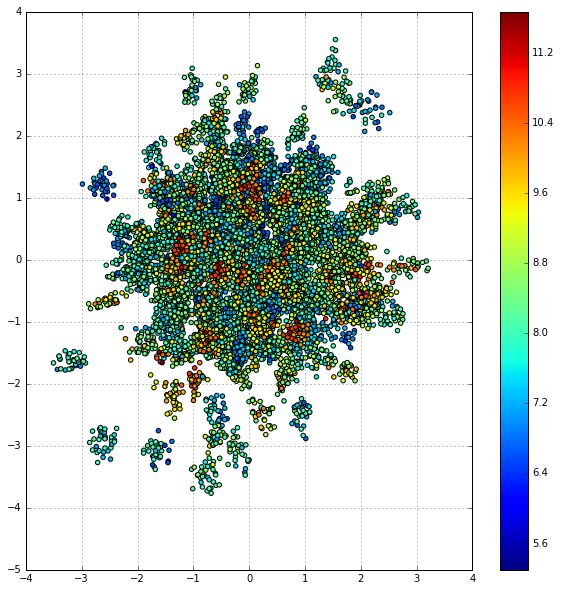

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(encoder.predict(X)[:, 0], encoder.predict(X)[:, 1], c=y)
plt.colorbar()
plt.grid()

In [32]:
# Save Variational Auto Encoder 
vae.save_weights("model/vae.hdf5")
